In [53]:
# Core
import pandas as pd
import numpy as np
import datetime as dt

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# ML / Forecasting
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Time series models (optional)
from statsmodels.tsa.seasonal import seasonal_decompose
from prophet import Prophet  # or NeuralProphet


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

salesdaily = pd.read_csv('salesdaily.csv')

# Build dataframe
df = pd.DataFrame({
    "date": salesdaily['datum'],
    "medicine_use": salesdaily['M01AE']
})

# convert date in corect format
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df = df.asfreq('D').fillna(0)


Index(['medicine_use'], dtype='object')

In [82]:
import requests
import pandas as pd

# Ensure the index is datetime
df.index = pd.to_datetime(df.index)

# --- 1️⃣ Fetch full weather data for overall range ---
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
    "latitude": 19.0760,
    "longitude": 72.8777,
    "start_date": df.index.min().strftime("%Y-%m-%d"),
    "end_date": df.index.max().strftime("%Y-%m-%d"),
    "daily": ["temperature_2m_max", "temperature_2m_min", "precipitation_sum"],
    "timezone": "Asia/Kolkata"
}

response = requests.get(url, params=params)
weather_data = response.json()

# --- 2️⃣ Convert to DataFrame ---
weather_df = pd.DataFrame(weather_data['daily'])
weather_df['date'] = pd.to_datetime(weather_df['time'])
weather_df.drop(columns=['time'], inplace=True)
weather_df.set_index('date', inplace=True)

# --- 3️⃣ Filter only for dates present in df.index ---
filtered_weather = weather_df.loc[weather_df.index.intersection(df.index)].copy()

# --- 4️⃣ Merge with main df ---
merged_df = df.join(filtered_weather, how='left')

merged_df.columns


Index(['medicine_use', 'temperature_2m_max', 'temperature_2m_min',
       'precipitation_sum'],
      dtype='object')

In [186]:
import pandas as pd
from serpapi import GoogleSearch

# --- 1. Helper Function to Get Trend Data (Corrected) ---
def get_weekly_trends(api_key, query_term, start_date, end_date, geo='IN'):
    """
    Fetches weekly Google Trends data from SerpApi for a given term and date range.
    """
    params = {
        "api_key": api_key,
        "engine": "google_trends",
        "q": query_term,
        "data_type": "TIMESERIES",
        "date": f"{start_date} {end_date}",
        "geo": geo,
        "output": "json"
    }

    try:
        search = GoogleSearch(params)
        results = search.get_dict()

        time_series = results.get("interest_over_time", {}).get("timeline_data", [])

        if not time_series:
            print(f"No timeline data returned for '{query_term}'")
            return pd.DataFrame()

        # --- START FIX ---
        # The 'value' is nested in a list, so we parse it manually
        parsed_data = []
        for item in time_series:
            if item.get('values'):
                parsed_data.append({
                    'timestamp': item['timestamp'],  # Use timestamp for easy date conversion
                    'value': item['values'][0]['value'] # This was the line causing the error
                })

        if not parsed_data:
            print(f"Data was returned but 'values' key was missing for '{query_term}'")
            return pd.DataFrame()

        df = pd.DataFrame(parsed_data)
        # --- END FIX ---

        df = df.rename(columns={"value": f"{query_term}_trend"})

        # Convert value to numeric
        df[f"{query_term}_trend"] = pd.to_numeric(df[f"{query_term}_trend"])

        # Convert timestamp to datetime and set as index
        df['date'] = pd.to_datetime(df['timestamp'], unit='s')
        df = df.set_index('date').drop(columns=['timestamp'])

        # Resample to 'W' (end of week Sunday) to standardize the dates for merging
        df = df.resample('W').mean()
        df.reset_index(inplace=True)

        return df

    except Exception as e:
        print(f"Error fetching data for '{query_term}': {e}")
        return pd.DataFrame()

# --- 2. Define Your Parameters ---
API_KEY = "82c16afe00da4baee26e5661b965e52597360704492da1020c07c91664f79056"  # <-- IMPORTANT: Get this from your SerpApi dashboard
START_DATE = "2014-02-01"
END_DATE = "2019-10-08"
GEO = "IN"
TERMS = ['back pain', 'joint pain', 'flu', 'paracetamol', 'ibuprofen', 'fever', 'cold']

# --- 3. Fetch Data for All Terms ---
# (This part is the same as before)
all_trends_df = pd.DataFrame()

for term in TERMS:
    print(f"Fetching data for '{term}'...")
    trend_df = get_weekly_trends(API_KEY, term, START_DATE, END_DATE, GEO)

    if all_trends_df.empty:
        all_trends_df = trend_df
    else:
        if not trend_df.empty:
            all_trends_df = all_trends_df.merge(trend_df, on='date', how='outer')

# --- 4. Prepare for Merging with Main Data ---
# (This part is the same as before)
all_trends_df.ffill(inplace=True)
all_trends_df.bfill(inplace=True)

all_trends_df.head


Fetching data for 'back pain'...


/var/folders/rh/1hl_5xn97f1f0q3yk6djqmq40000gn/T/ipykernel_83486/2151783003.py:52: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df['date'] = pd.to_datetime(df['timestamp'], unit='s')


Fetching data for 'joint pain'...


/var/folders/rh/1hl_5xn97f1f0q3yk6djqmq40000gn/T/ipykernel_83486/2151783003.py:52: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df['date'] = pd.to_datetime(df['timestamp'], unit='s')


Fetching data for 'flu'...


/var/folders/rh/1hl_5xn97f1f0q3yk6djqmq40000gn/T/ipykernel_83486/2151783003.py:52: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df['date'] = pd.to_datetime(df['timestamp'], unit='s')


Fetching data for 'paracetamol'...


/var/folders/rh/1hl_5xn97f1f0q3yk6djqmq40000gn/T/ipykernel_83486/2151783003.py:52: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df['date'] = pd.to_datetime(df['timestamp'], unit='s')


Fetching data for 'ibuprofen'...


/var/folders/rh/1hl_5xn97f1f0q3yk6djqmq40000gn/T/ipykernel_83486/2151783003.py:52: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df['date'] = pd.to_datetime(df['timestamp'], unit='s')


Fetching data for 'fever'...


/var/folders/rh/1hl_5xn97f1f0q3yk6djqmq40000gn/T/ipykernel_83486/2151783003.py:52: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df['date'] = pd.to_datetime(df['timestamp'], unit='s')


Fetching data for 'cold'...


/var/folders/rh/1hl_5xn97f1f0q3yk6djqmq40000gn/T/ipykernel_83486/2151783003.py:52: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df['date'] = pd.to_datetime(df['timestamp'], unit='s')


<bound method NDFrame.head of           date  back pain_trend  joint pain_trend  flu_trend  \
0   2014-02-02             62.0              46.0        1.0   
1   2014-02-09             62.0              46.0        1.0   
2   2014-02-16             62.0              46.0        1.0   
3   2014-02-23             62.0              46.0        1.0   
4   2014-03-02             64.0              43.0        1.0   
..         ...              ...               ...        ...   
292 2019-09-08             91.0              57.0        3.0   
293 2019-09-15             91.0              57.0        3.0   
294 2019-09-22             91.0              57.0        3.0   
295 2019-09-29             91.0              57.0        3.0   
296 2019-10-06             91.0              55.0        2.0   

     paracetamol_trend  ibuprofen_trend  fever_trend  cold_trend  
0                 29.0             42.0         22.0        58.0  
1                 29.0             42.0         22.0        58.0  


In [153]:
# --- 5. Merge ALL Fetched Trends ---
# This replaces your old merge cell

# <-- FIX 2: Reset index of merged_df so 'date' is a column for merging
merged_df_reset = merged_df.reset_index()

# <-- FIX 3: Merge the reset df with ALL columns from all_trends_df
data = merged_df_reset.merge(all_trends_df, on='date', how='left')

# Set 'date' back as the index for time series analysis
data.set_index('date', inplace=True)
data['date'] = data.index.to_period('D').to_timestamp()
# <-- FIX 4: Use modern .ffill() / .bfill() syntax
data.ffill(inplace=True)
data.bfill(inplace=True)


In [154]:
# --- Updated Feature Engineering for WEEKLY data ---

# Create time-based features
data['month'] = data.index.month
data['weekofyear'] = data.index.isocalendar().week # More specific than just dayofweek

# --- FIX: Update lags for WEEKLY data ---
# Lags of 1, 2, and 4 weeks (captures recent and monthly patterns)
for lag in [1, 2, 4]:
    data[f'use_lag_{lag}'] = data['medicine_use'].shift(lag)

# --- FIX: Update rolling features for WEEKLY data ---
# 4-week (approx 1 month) rolling average
data['rolling_mean_4'] = data['medicine_use'].rolling(4).mean()
data['rolling_std_4'] = data['medicine_use'].rolling(4).std() # Volatility

# Week-over-week difference (paper mentions differencing)
data['use_diff_1'] = data['medicine_use'].diff(1)

# Drop all NaNs created by lags/rolling features
data = data.dropna()


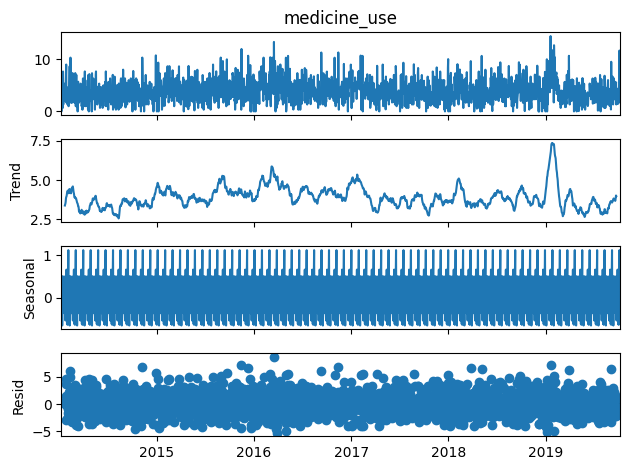

In [155]:
result = seasonal_decompose(data['medicine_use'], model='additive', period=28)
result.plot()
plt.show()


In [156]:
X = data.drop(columns=['medicine_use'])
X = X.select_dtypes(include=['float64', 'int64'])

y = data['medicine_use']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
model = RandomForestRegressor(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

preds = model.predict(X_test)
print("MAE:", mean_absolute_error(y_test, preds))
print("R2:", r2_score(y_test, preds))



MAE: 0.2143438692599173
R2: 0.9622962754829951


In [181]:
import numpy as np
from sklearn.model_selection import train_test_split

# --- Model Preparation ---
# This assumes your 'data_clean' DataFrame (from Cell 5) is ready.

# Define features (X) and target (y)
features = [col for col in data_clean.columns if col not in ['medicine_use']]
X = data_clean[features]
y = data_clean['medicine_use']

# Apply Log Transform to 'y' to stabilize variance from spikes
y_log = np.log1p(y)

# --- Validation Strategy (from Paper) ---
# "Train-test split validation with one last year of data (52 rows) was used for testing"
test_size = 152  # <-- This is the definition you were missing

# Create the training and test sets
X_train, X_test = X.iloc[:-test_size], X.iloc[-test_size:]
y_train, y_test = y.iloc[:-test_size], y.iloc[-test_size:]
y_train_log, y_test_log = y_log.iloc[:-test_size], y_log.iloc[-test_size:]

print(f"Test size defined as: {test_size} weeks")
print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

Test size defined as: 152 weeks
Training data shape: (1950, 18)
Test data shape: (152, 18)


23:43:23 - cmdstanpy - INFO - Chain [1] start processing


Prophet will be trained with 18 exogenous features:
['temperature_2m_max', 'temperature_2m_min', 'precipitation_sum', 'back pain_trend', 'joint pain_trend', 'flu_trend', 'paracetamol_trend', 'ibuprofen_trend', 'fever_trend', 'cold_trend', 'month', 'weekofyear', 'use_lag_1', 'use_lag_2', 'use_lag_4', 'rolling_mean_4', 'rolling_std_4', 'use_diff_1']


23:43:23 - cmdstanpy - INFO - Chain [1] done processing


✅ Future DF types before Prophet forecast:
temperature_2m_max           float64
temperature_2m_min           float64
precipitation_sum            float64
back pain_trend              float64
joint pain_trend             float64
flu_trend                    float64
paracetamol_trend            float64
ibuprofen_trend              float64
fever_trend                  float64
cold_trend                   float64
month                        float64
weekofyear                   float64
use_lag_1                    float64
use_lag_2                    float64
use_lag_4                    float64
rolling_mean_4               float64
rolling_std_4                float64
use_diff_1                   float64
ds                    datetime64[ns]
dtype: object

--- Prophet Model Results (Optimized Daily Forecast) ---
MAE: 0.40
R2: 0.84


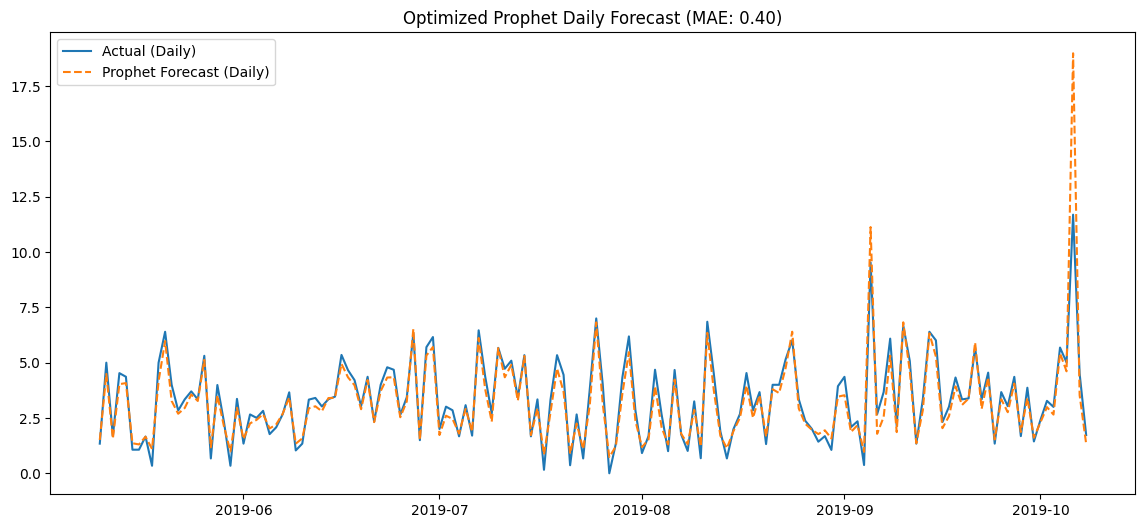

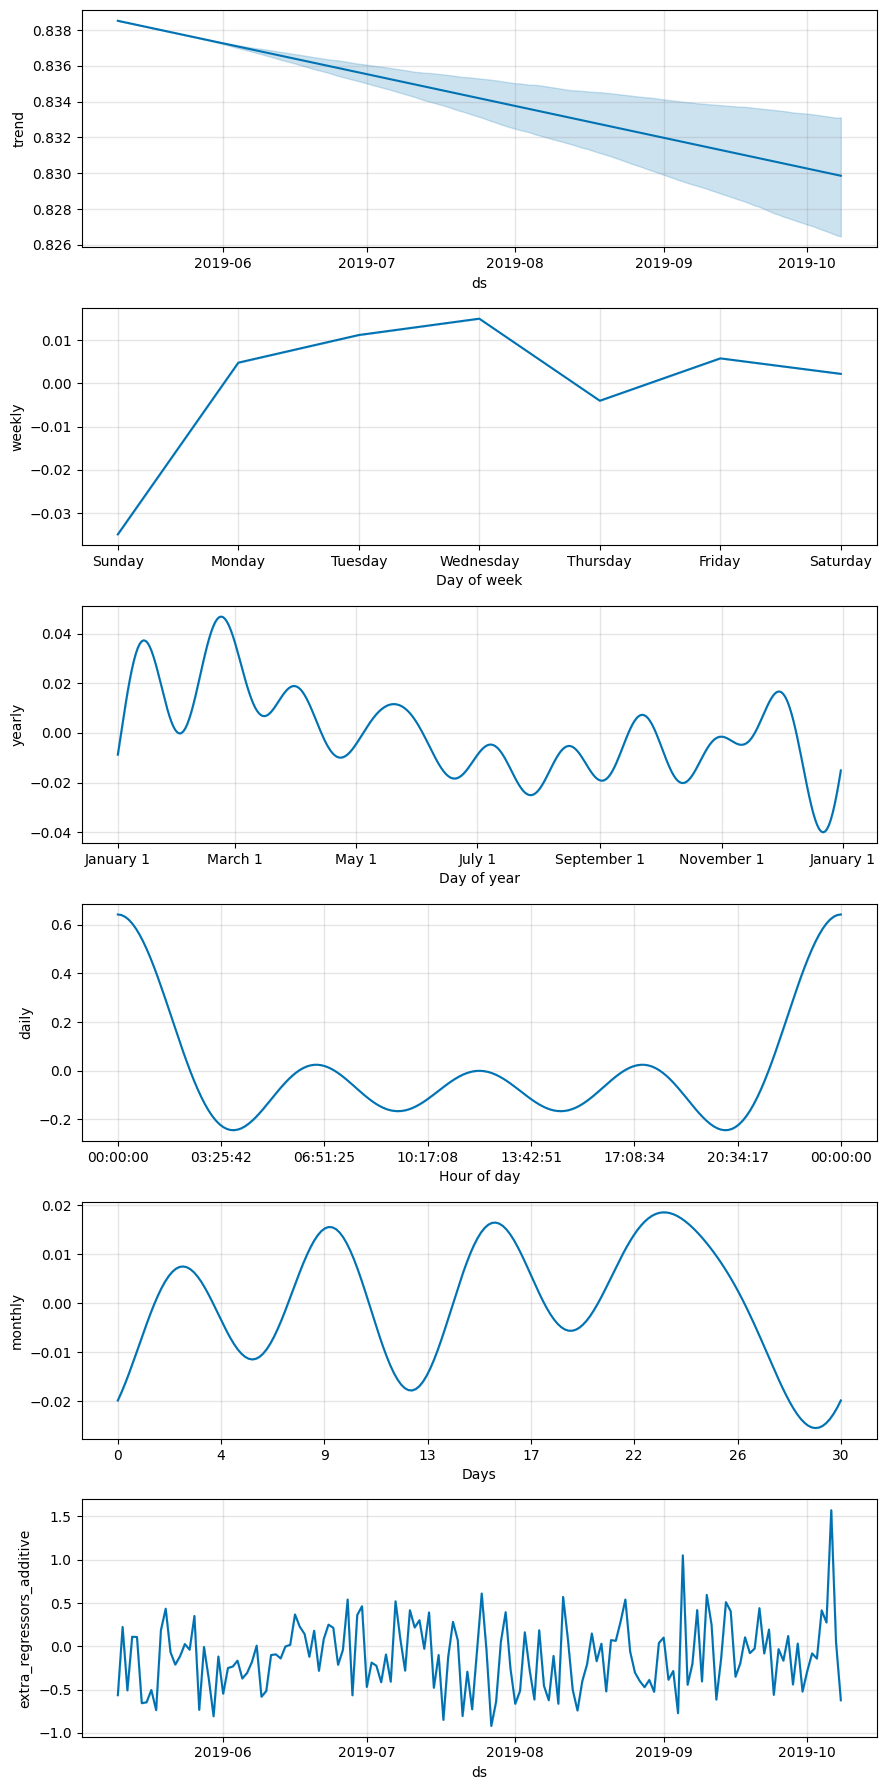

In [182]:
from prophet import Prophet
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

# --- Feature Setup ---
autoreg_features = ['use_lag_1', 'use_lag_2', 'use_lag_4',
                    'rolling_mean_4', 'rolling_std_4', 'use_diff_1']
exog_features = [col for col in X_train.columns]  # include all, including autoreg

print(f"Prophet will be trained with {len(exog_features)} exogenous features:")
print(exog_features)

# --- Scale Regressors ---
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train[exog_features]),
                              index=X_train.index, columns=exog_features)
X_test_scaled = pd.DataFrame(scaler.transform(X_test[exog_features]),
                             index=X_test.index, columns=exog_features)

# --- Force Daily Frequency ---
X_train_scaled = X_train_scaled.asfreq('D').ffill().fillna(0)
X_test_scaled = X_test_scaled.asfreq('D').ffill().fillna(0)
y_train_log = y_train_log.asfreq('D').ffill()
y_test_log = y_test_log.asfreq('D').ffill()

# --- Prophet Training Data ---
df_prophet_train = X_train_scaled.copy()
df_prophet_train['ds'] = y_train_log.index
df_prophet_train['y'] = y_train_log.values
df_prophet_train = df_prophet_train.ffill().fillna(0)

# --- Configure Prophet ---
m = Prophet(
    growth='linear',
    changepoint_prior_scale=0.5,
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=True
)

# Add monthly seasonality
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)

# Add all regressors
for col in exog_features:
    m.add_regressor(col)

# --- Train ---
m.fit(df_prophet_train)

# --- Prepare Future Data ---
future_df = X_test_scaled.copy()
future_df['ds'] = y_test_log.index
future_df = future_df.ffill().fillna(0)

print("✅ Future DF types before Prophet forecast:")
print(future_df.dtypes)

# --- Predict ---
forecast = m.predict(future_df)

# --- Inverse Transform ---
final_preds_prophet = np.expm1(forecast['yhat'])

# --- Evaluate ---
mae_prophet = mean_absolute_error(y_test.values, final_preds_prophet)
r2_prophet = r2_score(y_test.values, final_preds_prophet)

print(f"\n--- Prophet Model Results (Optimized Daily Forecast) ---")
print(f"MAE: {mae_prophet:.2f}")
print(f"R2: {r2_prophet:.2f}")

# --- Plot ---
plt.figure(figsize=(14, 6))
plt.plot(y_test.index, y_test, label='Actual (Daily)')
plt.plot(y_test.index, final_preds_prophet.values, label='Prophet Forecast (Daily)', linestyle='--')
plt.legend()
plt.title(f"Optimized Prophet Daily Forecast (MAE: {mae_prophet:.2f})")
plt.show()

m.plot_components(forecast)
plt.show()
